DECISION TREE ALGORITHM. PREDICIENDO LA DIABETES

    Objetivo: Predecir en base a medidas diagnósticas si un paciente tiene o no diabetes.

In [56]:
!pip install missingno lazypredict
!pip install statsmodels
!pip install imbalanced-learn
!pip install joblib


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [57]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text, DecisionTreeRegressor
from sklearn.metrics import *
from imblearn.metrics import specificity_score
from sklearn.model_selection import GridSearchCV
import joblib
import os

1. Carga del conjunto de datos.

In [11]:
#1) Descargo los datos de diabetes:

#a) Leo los datos de la URL.
url = "https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv"

#b) Guardo los datos en un DataFrame.
df = pd.read_csv(url)

#c) Miro las primeras filas del DF.
print(df.head())


   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


2. Realiza un EDA

In [12]:
# Tamaño de la muestra.
df.shape   # La BD tiene 768 filas y 9 columnas.

# Información de los datos.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Todas las variables son numéricas, por lo que no tengo que codificar ninguna variable.

In [13]:
# Cuento el número de valores únicos en cada columna del DF.
df.nunique()

Pregnancies                  17
Glucose                     136
BloodPressure                47
SkinThickness                51
Insulin                     186
BMI                         248
DiabetesPedigreeFunction    517
Age                          52
Outcome                       2
dtype: int64

No hay variables que tengan valores constantes.

In [14]:
# Evaluo la incidencia de los valores perdidos en cada una de las variables (Nan).
df.isnull().mean()*100

Pregnancies                 0.0
Glucose                     0.0
BloodPressure               0.0
SkinThickness               0.0
Insulin                     0.0
BMI                         0.0
DiabetesPedigreeFunction    0.0
Age                         0.0
Outcome                     0.0
dtype: float64

Ninguna variable tiene valores NaN.

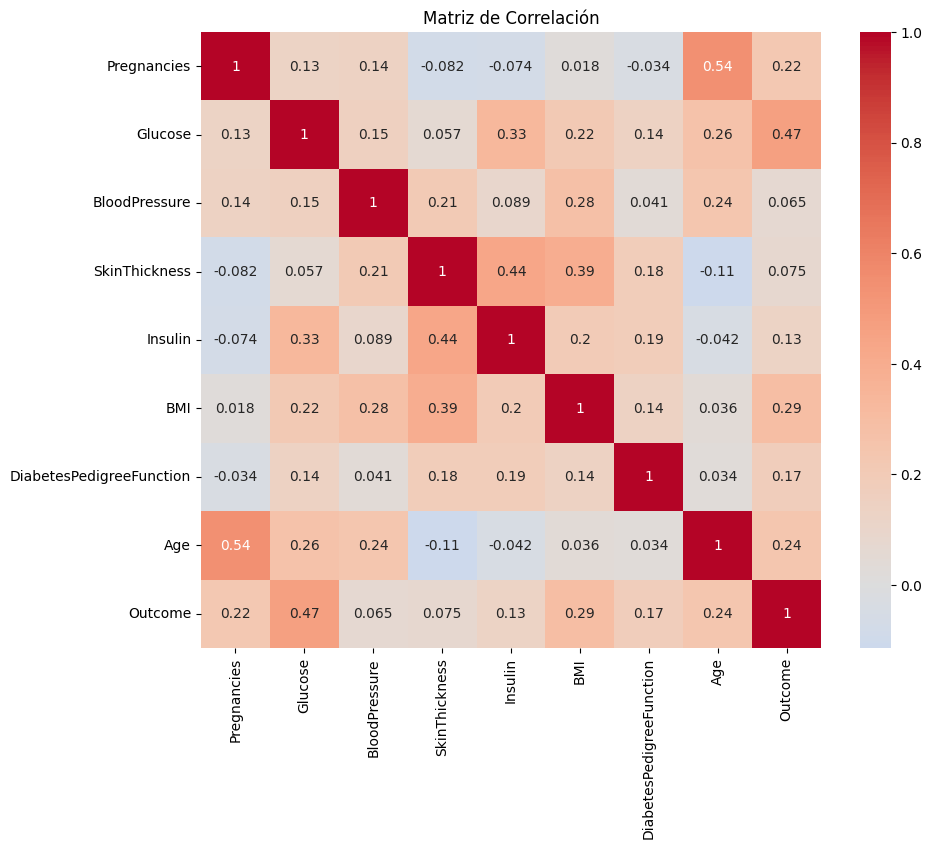

In [15]:
# Anñalisis de correlación
correlation_matrix = df.corr()

# Grafico mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Matriz de Correlación")
plt.show()


No se observa que las variables de la matriz X estén correlacionadas entre sí. 

In [16]:
# Limpio las columnas del DF.

# Quito la columna que considero que no tiene valor predictivo (SkinThickness):
df.drop(columns=['SkinThickness'], inplace=True)

Nota para Félix: Mirando en internet si existe alguna relación entre la variables SkinThickness y la diabetes, encuentro que es una variable que está relacionada con el IMC, pero que, dado que es un indicador de grasa subcutánea y no visceral, no guarda relación con la diabetes.


In [17]:
# Análisis descriptivo de la muestra.
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


BMI:

-Los valores mínimos y máximos de BMI son iguales a 0 y 67.10. Estos valores tan extremos hace pensar que existen valores atípicos en la muestra.

-Al parecer las personas con hiperobesidad tienen un IMC mayor que 60. Dado que considero que puede existir relación entre la obesidad y la diabetes, he preferido no eliminar estas observaciones de la muestra. 

PREGNANCIES:

-El valor máximo de embarazos es 17. Es un valor muy elevado y casi imposible de creer, por lo que evidencia la existencia de un posible error en la toma de los datos.



Análisis BMI:

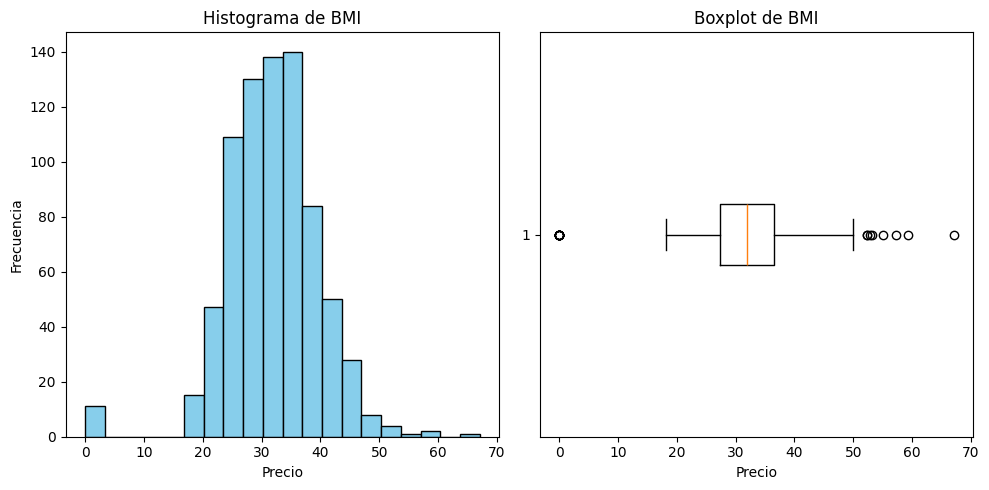

In [18]:
# Creo una figura con dos subplots (uno para el histograma y otro para el boxplot)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Creo un histograma en el primer subplot
ax[0].hist(df['BMI'], bins=20, color='skyblue', edgecolor='black')
ax[0].set_title('Histograma de BMI')
ax[0].set_xlabel('Precio')
ax[0].set_ylabel('Frecuencia')

# Creo un boxplot en el segundo subplot
ax[1].boxplot(df['BMI'], vert=False)
ax[1].set_title('Boxplot de BMI')
ax[1].set_xlabel('Precio')

# Muestro la figura
plt.tight_layout()
plt.show()

In [19]:
# Consulto qué observaciones tienen un BMI cercano a cero. Para ello, y viendo el gráfico, establezco la restricción de que tomen valores menores a 10.
bmi_bajo = df[df['BMI'] < 10]
print(bmi_bajo.index)

Index([9, 49, 60, 81, 145, 371, 426, 494, 522, 684, 706], dtype='int64')


In [20]:
# Me quedo con los id que tienen un BMI mayor que 10.
df = df[df['BMI'] >= 10]

In [21]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,757.0,3.844122,3.369959,0.000,1.000,3.000,6.000,17.00
Glucose,757.0,121.136063,32.061428,0.000,99.000,117.000,141.000,199.00
BloodPressure,757.0,69.690885,18.283325,0.000,64.000,72.000,80.000,122.00
Insulin,757.0,80.841480,115.710818,0.000,0.000,37.000,130.000,846.00
BMI,757.0,32.457464,6.924988,18.200,27.500,32.300,36.600,67.10
DiabetesPedigreeFunction,757.0,0.472437,0.329474,0.078,0.244,0.376,0.627,2.42
Age,757.0,33.281374,11.697752,21.000,24.000,29.000,41.000,81.00
Outcome,757.0,0.351387,0.477719,0.000,0.000,0.000,1.000,1.00


Se han eliminado correctamente los valores atípicos inferiores de la muestra.

Análisis PREGNANCIES

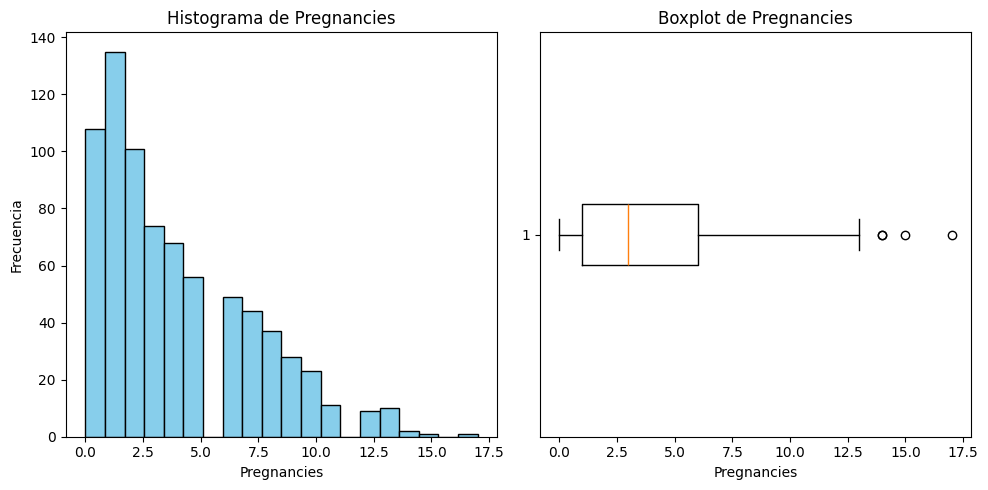

In [22]:
# Creo una figura con dos subplots (uno para el histograma y otro para el boxplot)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Creo un histograma en el primer subplot
ax[0].hist(df['Pregnancies'], bins=20, color='skyblue', edgecolor='black')
ax[0].set_title('Histograma de Pregnancies')
ax[0].set_xlabel('Pregnancies')
ax[0].set_ylabel('Frecuencia')

# Creo un boxplot en el segundo subplot
ax[1].boxplot(df['Pregnancies'], vert=False)
ax[1].set_title('Boxplot de Pregnancies')
ax[1].set_xlabel('Pregnancies')

# Muestro la figura
plt.tight_layout()
plt.show()

In [23]:
# Creo un df en el que ordeno la variable Pregnancies de mayor a menor.
df_sorted = df.sort_values(by='Pregnancies', ascending=False)

# Creo un df con las variables Pregnancies y Age, siguiendo el orden del df anterior.
df_selected = df_sorted[['Pregnancies', 'Age']]

# Muestro la tabla de datos ordenados.
print(df_selected.head(30))

     Pregnancies  Age
159           17   47
88            15   43
455           14   38
298           14   46
72            13   42
28            13   57
744           13   39
518           13   41
357           13   44
323           13   43
274           13   52
691           13   44
635           13   38
86            13   45
582           12   62
510           12   46
745           12   46
436           12   41
375           12   58
254           12   44
215           12   38
333           12   44
358           12   48
558           11   42
559           11   35
36            11   35
658           11   51
24            11   51
590           11   45
614           11   50


Tras analizar los datos, observo que es común que haya mujeres con un elevado número de hijos. Asimismo, analizo las edades de estas mujeres para ver que no haya ningún posible error en los datos, es decir, mujeres muy jóvenes con muchos hijos. Por lo tanto, considero que lo más adecuado es mantener estas observaciones en la muestra.

In [24]:
# Muestro la distribución de la variable dependiente "Outcome".
df.Outcome.value_counts()

Outcome
0    491
1    266
Name: count, dtype: int64

La distribución de la variable muestra que hay 491 pacientes sin diabetes y 266 con diabetes. 

In [25]:
# Divido el conjunto de datos en Train y Test.
X_train, X_test, y_train, y_test = train_test_split(df.drop('Outcome', axis=1), df.Outcome, test_size=0.2, random_state=42)

3. Construye un modelo de árbol de decisión.

In [26]:
# Defino y entreno dos modelos de clasificación (complejo y simple) utilizando árboles de decisión.
complex_tree = DecisionTreeClassifier(max_depth=100, min_samples_leaf=1, random_state=42).fit(X_train, y_train)
simple_tree = DecisionTreeClassifier(max_depth=3, min_samples_leaf=20, max_features=X_train.shape[1]//2, random_state=42).fit(X_train, y_train)

y_pred_train_complex = complex_tree.predict(X_train)
y_pred_test_complex = complex_tree.predict(X_test)

y_pred_train_simple = simple_tree.predict(X_train)
y_pred_test_simple = simple_tree.predict(X_test)

In [27]:
# Cálculo de métricas para Train, Test, y la diferencia entre ambos.
def get_metrics(y_train, y_test, y_pred_train, y_pred_test):
    # Calcular métricas para el conjunto de entrenamiento
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_f1 = f1_score(y_train, y_pred_train)
    train_auc = roc_auc_score(y_train, y_pred_train)
    train_precision = precision_score(y_train, y_pred_train)
    train_recall = recall_score(y_train, y_pred_train)
    train_specificity = specificity_score(y_train, y_pred_train)

    # Calcular métricas para el conjunto de prueba
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test)
    test_auc = roc_auc_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_specificity = specificity_score(y_test, y_pred_test)

    # Calcular la diferencia entre métricas de entrenamiento y prueba
    diff_accuracy = train_accuracy - test_accuracy
    diff_f1 = train_f1 - test_f1
    diff_auc = train_auc - test_auc
    diff_precision = train_precision - test_precision
    diff_recall = train_recall - test_recall
    diff_specificity = train_specificity - test_specificity

    # Crear un DataFrame con los resultados
    metrics_df = pd.DataFrame([[train_accuracy, train_f1, train_auc, train_precision, train_recall, train_specificity],[test_accuracy, test_f1, test_auc, test_precision, test_recall, test_specificity],[diff_accuracy, diff_f1, diff_auc, diff_precision, diff_recall, diff_specificity]],
                              columns = ['Accuracy', 'F1', 'AUC', 'Precision', 'Recall', 'Specificity'],
                              index = ['Train','Test', 'Diferencia'])

    return metrics_df

In [28]:
# Métricas del modelo complejo.
get_metrics(y_train, y_test, y_pred_train_complex, y_pred_test_complex)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,1.000000,1.00000,1.000000,1.000000,1.000000,1.00000
Test,0.684211,0.59322,0.673852,0.555556,0.636364,0.71134
Diferencia,0.315789,0.40678,0.326148,0.444444,0.363636,0.28866


Dado que la diferencia entre las métricas de entrenamiento y de prueba es grande, es plausible pensar que el modelo está demasiado ajustado a los datos de entrenamiento y hay overfitting. El modelo ha apredido muy bien las particularidades del conjunto de entrenamiento y no es capaz de generalizar bien sobre el conjunto de prueba.

In [29]:
# Métricas del modelo simple.
get_metrics(y_train, y_test, y_pred_train_simple, y_pred_test_simple)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,0.773554,0.649616,0.733689,0.705556,0.601896,0.865482
Test,0.723684,0.588235,0.685098,0.638298,0.545455,0.824742
Diferencia,0.049870,0.061381,0.048591,0.067258,0.056441,0.040740


Las diferencias entre las métricas del modelo de entrenamiento y de prueba son relativamente pequeñas. Por lo tanto, el modelo tiene un buen equilibrio entre ajuste y generalización. Por otro lado, los resultados en el modelo de prueba indican que, si bien hay margen para mejorar el rendimiento en la prueba, no parece haber overfitting.

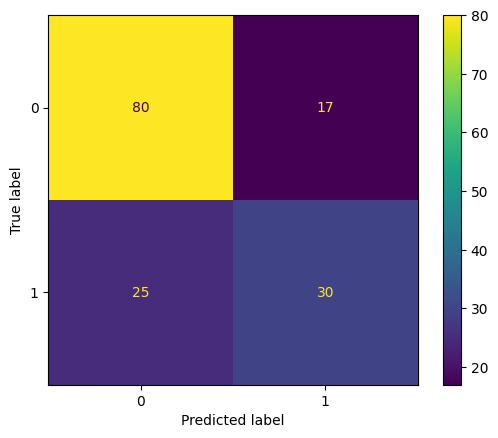

In [30]:
# Matriz de confusión para el mejor modelo, que es el modelo simple.
cm = confusion_matrix(y_test, y_pred_test_simple)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'])
disp.plot()

Hay 80 pacientes sin diabetes que han sido clasificadas correctamente en la clase sin diabetes (Verdadero negativo).

Hay 30 pacientes con diabetes que han sido correctamente clasificados como paciente con diabetes (Verdadero positivo).

Hay 17 pacientes sin diabetes que han sido clasificadas erroneamente como si tuvieran diabetes (Falso positivo).

Hay 30 pacientes con diabetes que han sido clasificadas erronamente como pacientes sin diabetes (Falso negativo).

[Text(0.5, 0.875, 'Age <= 28.5\ngini = 0.454\nsamples = 605\nvalue = [394, 211]\nclass = 0'),
 Text(0.25, 0.625, 'BMI <= 30.95\ngini = 0.314\nsamples = 282\nvalue = [227, 55]\nclass = 0'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'Glucose <= 127.5\ngini = 0.094\nsamples = 141\nvalue = [134, 7]\nclass = 0'),
 Text(0.0625, 0.125, 'gini = 0.0\nsamples = 117\nvalue = [117, 0]\nclass = 0'),
 Text(0.1875, 0.125, 'gini = 0.413\nsamples = 24\nvalue = [17, 7]\nclass = 0'),
 Text(0.375, 0.375, 'Glucose <= 127.5\ngini = 0.449\nsamples = 141\nvalue = [93, 48]\nclass = 0'),
 Text(0.3125, 0.125, 'gini = 0.273\nsamples = 92\nvalue = [77, 15]\nclass = 0'),
 Text(0.4375, 0.125, 'gini = 0.44\nsamples = 49\nvalue = [16.0, 33.0]\nclass = 1'),
 Text(0.75, 0.625, 'Glucose <= 154.5\ngini = 0.499\nsamples = 323\nvalue = [167, 156]\nclass = 0'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'Insulin <= 121.0\ngini = 0.477\nsamples = 252\nvalue = [153, 99]\nclass = 0'),
 Text(0.5625, 0.125, 'gini 

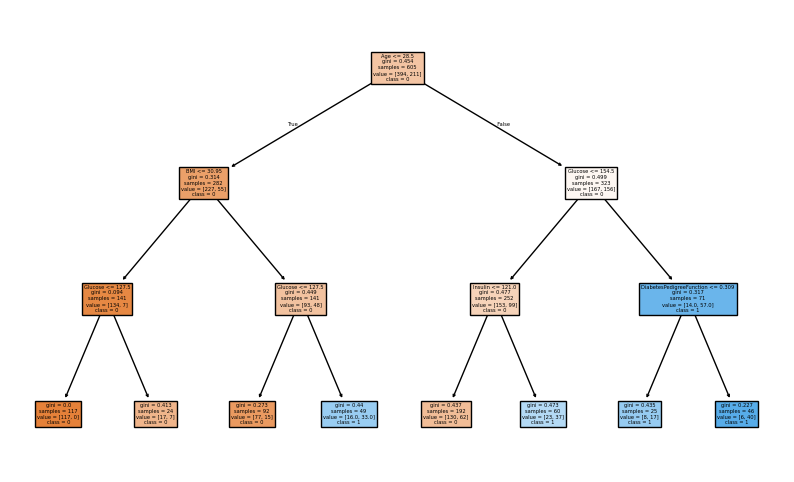

In [31]:
plt.figure(figsize=(10,6))
plot_tree(simple_tree, feature_names=list(X_train.columns), class_names=['0', '1'], filled=True)

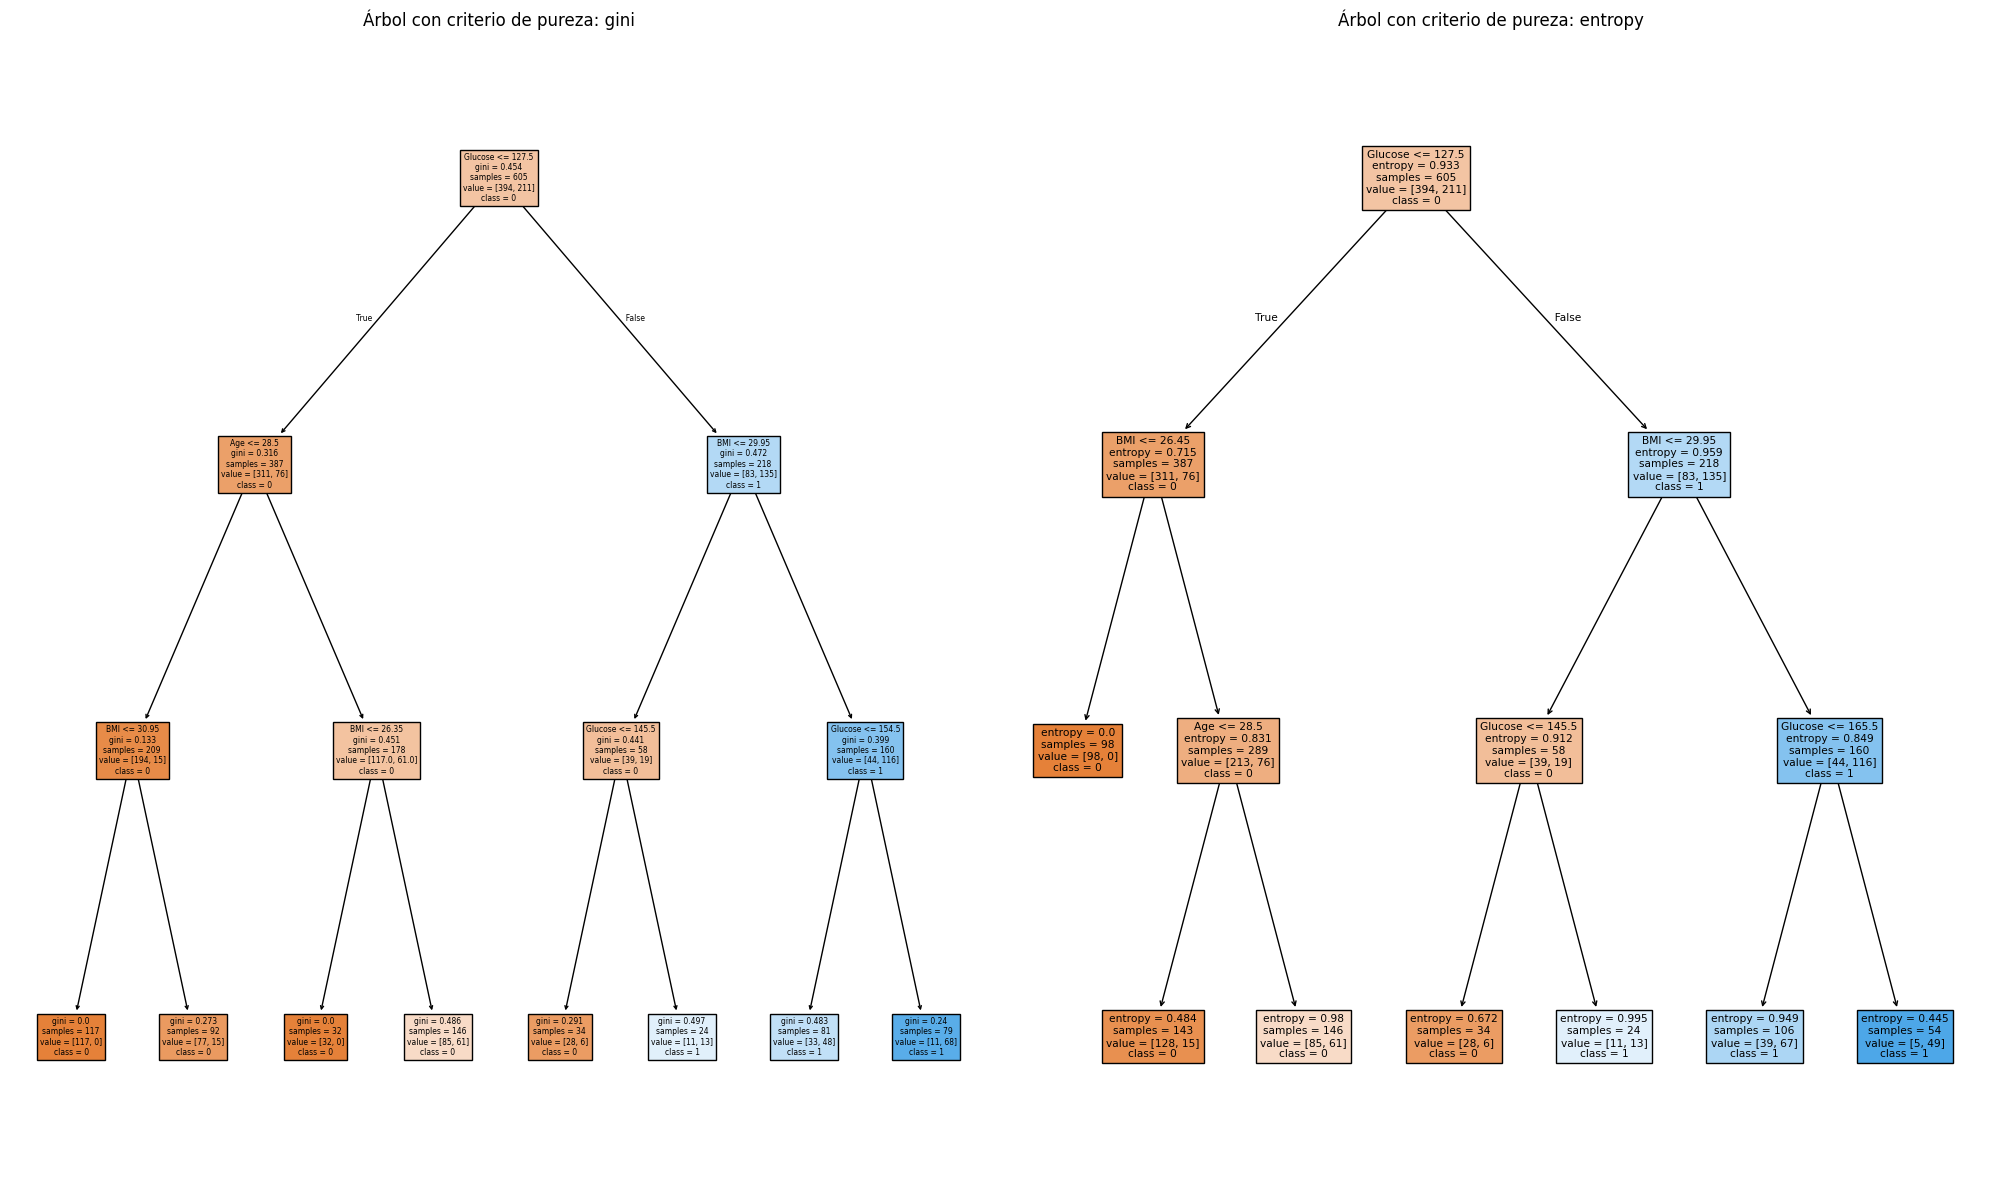

In [32]:
# Modifico la función de cálculo de la pureza de los nodos y utilizo todas las disponibles.

# Dividir los datos en conjuntos de entrenamiento y prueba de nuevo.
X = df.drop('Outcome', axis=1) 
y = df['Outcome']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creo una figura para los gráficos.
plt.figure(figsize=(20, 12))

# Lista de criterios.
criterios = ['gini', 'entropy']
n_criterios = len(criterios)

# Ajusto y grafico el árbol para cada criterio.
for i, criterio in enumerate(criterios):
    plt.subplot(1, n_criterios, i + 1)
    
    # Creo y ajusto el modelo.
    tree_model = DecisionTreeClassifier(criterion=criterio, max_depth=3, random_state=42)
    tree_model.fit(X_train, y_train)
    
    # Grafico del árbol.
    plot_tree(tree_model, feature_names=list(X_train.columns), class_names=['0', '1'], filled=True)
    plt.title(f"Árbol con criterio de pureza: {criterio}")

plt.tight_layout()
plt.show()


En primer lugar, en ambos modelos el primer nodo divide los datos según el rango de la variable "Glucose", por lo que es la característica más importante en la clasificación.

En segundo lugar, los nodos resultantes son similares en ambos árboles.

En tercer lugar, se observa mayor pureza en los nodos correspondientes al modelo estimado bajo el criterio de Gini. Por lo tanto, escojo este modelo como el "mejor modelo".

4. Optimizar el modelo anterior.

In [47]:
# Dividir los datos en conjuntos de entrenamiento y prueba de nuevo.
X = df.drop('Outcome', axis=1) 
y = df['Outcome']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Defino el clasificador.
tree = DecisionTreeClassifier(criterion='gini', random_state=42)

# Defino los hiperparámetros que quiero probar.
param_grid = {
    'max_depth': [3, 5, 10, 20, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': [None, 'sqrt', 'log2']
}

# Configuro el GridSearchCV.
grid_search = GridSearchCV(estimator=tree, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Ajusto el modelo al conjunto de entrenamiento.
grid_search.fit(X_train, y_train)

# Muestro los mejores hiperparámetros.
print(f"Mejores hiperparámetros: {grid_search.best_params_}")



Fitting 5 folds for each of 180 candidates, totalling 900 fits
Mejores hiperparámetros: {'max_depth': 5, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2}


/home/vscode/.local/lib/python3.10/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [51]:
# Mejor modelo para hacer predicciones.
best_tree = grid_search.best_estimator_
y_pred_train_g = best_tree.predict(X_train)
y_pred_test_g = best_tree.predict(X_test)

In [54]:
# Calculo las métricas.

def get_metrics(y_train, y_test, y_pred_train, y_pred_test):
    # Calcular métricas para el conjunto de entrenamiento
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_f1 = f1_score(y_train, y_pred_train)
    train_auc = roc_auc_score(y_train, y_pred_train)
    train_precision = precision_score(y_train, y_pred_train)
    train_recall = recall_score(y_train, y_pred_train)
    
    # Calcular métricas para el conjunto de prueba
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test)
    test_auc = roc_auc_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    
    # Calcular la diferencia entre métricas de entrenamiento y prueba
    diff_accuracy = train_accuracy - test_accuracy
    diff_f1 = train_f1 - test_f1
    diff_auc = train_auc - test_auc
    diff_precision = train_precision - test_precision
    diff_recall = train_recall - test_recall
    
    # Crear un DataFrame con los resultados
    metrics_df = pd.DataFrame([[train_accuracy, train_f1, train_auc, train_precision, train_recall],
                               [test_accuracy, test_f1, test_auc, test_precision, test_recall],
                               [diff_accuracy, diff_f1, diff_auc, diff_precision, diff_recall]],
                              columns=['Accuracy', 'F1', 'AUC', 'Precision', 'Recall'],
                              index=['Train', 'Test', 'Diferencia'])
    
    return metrics_df


In [55]:
get_metrics(y_train, y_test, y_pred_train_g, y_pred_test_g)

,Accuracy,F1,AUC,Precision,Recall
Train,0.839669,0.746736,0.802061,0.831395,0.677725
Test,0.750000,0.648148,0.725398,0.660377,0.636364
Diferencia,0.089669,0.098588,0.076662,0.171018,0.041361


A pesar de que el modelo funciona bien en el entrenamiento, su rendimiento cae significativamente en el conjunto de prueba. Por lo tanto, las diferencias entre las métricas de entrenamiento y prueba indica la existencia de overfitting.

Por otro lado, cabe destacar que el indicador Precision, que representa la proporción de verdaderos positivos entre todas las instancias que fueron clasificadas como positivos, es sustancialmente menor en el conjunto de prueba que en el de entrenamiento. En este sentido, podemos deducir que el modelo está realizando muchos más falsos positivos en el modelo de prueba que en el de entrenamiento.

5. Guardar el modelo.

In [59]:
# Defino la ruta y el nombre del archivo.
model_filename = '/workspaces/Proyecto17b_albaebauluz/models/model_tree.pkl'

# Guardo el modelo en la ruta especificada.
joblib.dump(best_tree, model_filename)

print(f"Modelo guardado en {model_filename}")


Modelo guardado en /workspaces/Proyecto17b_albaebauluz/models/model_tree.pkl
